#Classfication on Tensorflow

## Introduction

**TensorFlow Lite**

This notebooks shows training a TensorFlow Lite models
* [Testing TensorFlow Lite image classification mode](https://thinkmobile.dev/testing-tensorflow-lite-image-classification-model/)l - converting TensorFlow to TensorFlow Lite and comparing models side by side.




This notebooks shows some ways for debugging TensorFlow Lite models and comparing them with the original implementations in TensorFlow.


**TensorFlow 2.x and Colaboratory**

Examples presented in this notebook are built on top of TensorFlow 2.x beta version. This notebook was created only for the Colaboratory environment.

GPU support of Colab benefit is the training process of this notebook should be about 3 times faster than on CPU env.

## **Install requirements**


In [95]:
!pip install tensorflow-gpu==2.0.0-beta0
!pip install tensorflow_hub

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-beta0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-beta0


In [96]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

For better data visualization we'll use Pandas library.

In [97]:
import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

Verify system

In [98]:
print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.15.0
Hub version:  0.16.1
Eager mode:  True
GPU is available


## **Prepare dataset**

Connect your drive with your gmail

In [99]:
'''from google.colab import drive
drive.mount('/content/drive')'''

"from google.colab import drive\ndrive.mount('/content/drive')"

Set your training folder which contains images


In [100]:
data_root='/content/sample_data/cancerdataset';

Create data generator for training and validation

In [101]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)
print(TRAINING_DATA_DIR);
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR,
    subset="validation",
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR,
    subset="training",
    shuffle=True,
    target_size=IMAGE_SHAPE)

/content/sample_data/cancerdataset
Found 36 images belonging to 3 classes.
Found 144 images belonging to 3 classes.


Learn more about data batches

In [102]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 3)
['.Ipynb_Checkpoints' 'Benigen' 'Malignant']


# Training

As a base model for transfer learning, we'll use MobileNet v2 model stored on TensorFlow Hub. Presented model can be used only in TensorFlow 2.0 implementation (TF Hub contains also models for TensorFlow 1.x).
Basic information about feature vector:


*   Input shape: 224x224x3 (224x224 pixels, 3 chanels each, RGB format),
*   Each channel has value in range [0, 1],
*   Feature vector output shape: 1280 (number of labels classified by MobileNet is 1001 - this info isn't important here)

For more details check feature vector page: https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4




In [103]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 2261827 (8.63 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [104]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

*Lets Train Our model!*

In [105]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator,
    epochs=10,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Epoch 1/10
5/5 [==============================] - 8s 437ms/step - loss: 1.7999 - acc: 0.3819 - val_loss: 0.5676 - val_acc: 0.6389
Epoch 2/10
5/5 [==============================] - 2s 326ms/step - loss: 0.9050 - acc: 0.6181 - val_loss: 0.5254 - val_acc: 0.7222
Epoch 3/10
5/5 [==============================] - 1s 207ms/step - loss: 0.8821 - acc: 0.5903 - val_loss: 0.5950 - val_acc: 0.6111
Epoch 4/10
5/5 [==============================] - 1s 173ms/step - loss: 0.7701 - acc: 0.6042 - val_loss: 0.5926 - val_acc: 0.6389
Epoch 5/10
5/5 [==============================] - 1s 154ms/step - loss: 0.7198 - acc: 0.6250 - val_loss: 0.5083 - val_acc: 0.7500
Epoch 6/10
5/5 [==============================] - 1s 154ms/step - loss: 0.6417 - acc: 0.7014 - val_loss: 0.5817 - val_acc: 0.6667
Epoch 7/10
5/5 [==============================] - 1s 147ms/step - loss: 0.6034 - acc: 0.6875 - val_loss: 0.5780 - val_acc: 0.6944
Epoch 8/10
5/5 [==============================] - 1s 190ms/step - loss: 0.7170 - acc: 0.67

Measure accuracy and loss after training

In [106]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

2/2 [==============================] - 0s 29ms/step - loss: 0.5330 - acc: 0.6944
Final loss: 0.53
Final accuracy: 69.44%


# Exporting Model

We'll save our model as TensorFlow SavedModel format. After that we'll do inference on reloaded model, so if you come with a model already trained, it'll be easier to inspect it.

In [107]:
#pip install tf.keras.experimental.export_saved_model

In [108]:
SHOE_SAVED_MODEL = "saved_models/shoe"
model.save(SHOE_SAVED_MODEL)
#print(SHOE_SAVED_MODEL)
#tf.keras.experimental.export_saved_model(model, SHOE_SAVED_MODEL)

## Load TensorFlow SavedModel
Let's load TensorFlow model from SavedModel format. Because we used custom layer from TensorFlow Hub, we need to explicitly point out the implementation with custom_obiects param.

In [109]:
# to reload your model
shoe_model = tf.keras.models.load_model(SHOE_SAVED_MODEL,  custom_objects={'KerasLayer':hub.KerasLayer})

In [110]:
# Load SavedModel ANother Way
"""
shoe_model = tf.keras.experimental.load_from_saved_model(SHOE_SAVED_MODEL,
                                                            custom_objects={'KerasLayer':hub.KerasLayer})"""

"\nshoe_model = tf.keras.experimental.load_from_saved_model(SHOE_SAVED_MODEL, \n                                                            custom_objects={'KerasLayer':hub.KerasLayer})"

## Check predictions on loaded model

In [111]:
# Get images and labels batch from validation dataset generator

val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


Validation batch shape tells us that we have a batch of 32 images, with size and channels: 224x224x3.

Let's calculate predictions for the entire batch.

In [112]:
tf_model_predictions = shoe_model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

1/1 [==============================] - 1s 600ms/step
Prediction results shape: (32, 3)


Convert prediction results to Pandas dataframe, for better visualization

In [113]:
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,.Ipynb_Checkpoints,Benigen,Malignant
0,0.00013375,0.16666265,0.83320361
1,0.00004960,0.81753385,0.18241656
2,0.00022592,0.29808667,0.70168740
3,0.00000107,0.35329241,0.64670658
4,0.00010388,0.17952059,0.82037550


In [114]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

Print images batch and labels predictions

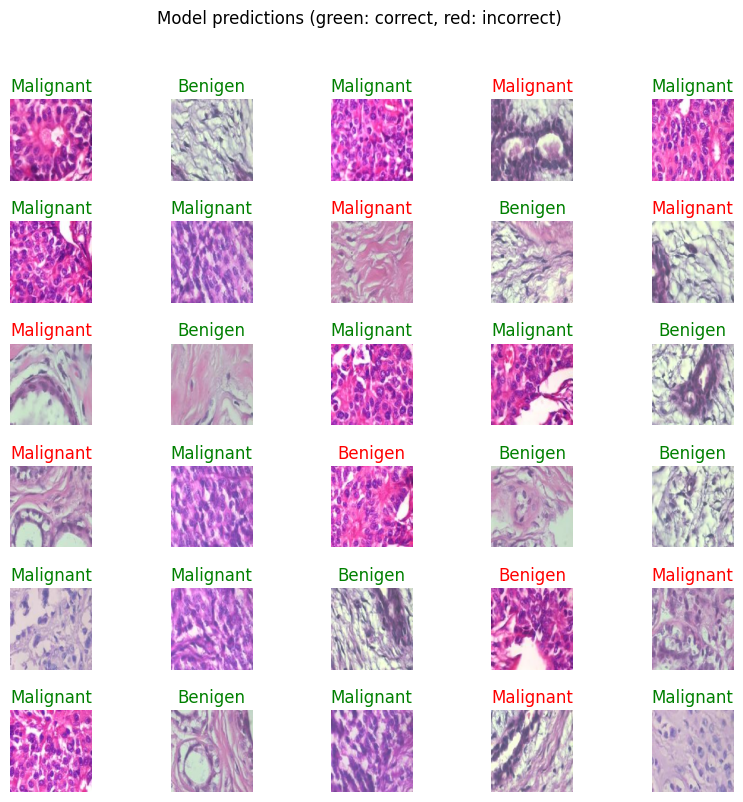

In [115]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])

  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Convert model to TFLite

Convert recently loaded model to TensorFlow Lite models (standard and quantized with a post-training quantization).

Because of TensorFlow 2.0 nature, we'll need to convert TensorFlow model into concrete function and then do conversion to TFLite.

In [116]:
!mkdir "tflite_models"

mkdir: cannot create directory ‘tflite_models’: File exists


In [117]:
TFLITE_MODEL = "tflite_models/cancer.tflite"
TFLITE_QUANT_MODEL = "tflite_models/cancer_quant.tflite"

In [118]:
"""# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : shoe_model(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

# Convert the model to quantized version with post-training quantization
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)

print("TFLite models and their sizes:")
!ls "tflite_models" -lh"""

'# Get the concrete function from the Keras model.\nrun_model = tf.function(lambda x : shoe_model(x))\n\n# Save the concrete function.\nconcrete_func = run_model.get_concrete_function(\n    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)\n)\n\n# Convert the model\nconverter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])\nconverted_tflite_model = converter.convert()\nopen(TFLITE_MODEL, "wb").write(converted_tflite_model)\n\n# Convert the model to quantized version with post-training quantization\nconverter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])\nconverter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]\ntflite_quant_model = converter.convert()\nopen(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)\n\nprint("TFLite models and their sizes:")\n!ls "tflite_models" -lh'